In [39]:
import numpy as np
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [40]:
class FCLayer:
    def __init__(self, input_size, output_size, activation, activation_prime):
        """
        Inicijalizacija sloja

        Args:
            input_size (int): broj ulaznih neurona
            output_size (int): broj izlaznih neurona
            activation (function): aktivaciona funkcija
            activation_prime (function): derivacija funkcije aktivacije
        """
        self.input = None
        self.output = None
        self.input_size = input_size
        self.output_size = output_size

        self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.random.rand(output_size, 1) - 0.5
        
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        """
        Propagacija ulaznih vrijednosti kroz sloj

        Args:
            input_data (numpy.array): ulazni podaci

        Returns:
            numpy.array: izlaz sloja
        """
        self.input = input_data

        # provjera dimenzija
        assert self.weights.shape[1] == input_data.shape[0], "dimenzije ulaza i tezina se ne poklapaju"
        self.zl = np.dot(self.weights, self.input) + self.bias
        self.output = self.activation(self.zl)

        return self.output

    def backward_propagation(self, output_error, learning_rate):
        """
        Propagacija greske unazad kroz sloj

        Args:
            output_error (numpy.array): greska izlaza
            learning_rate (float): stopa ucenja
        
        Returns:
            numpy.array: greska ulaza
        """
        deltal = self.activation_prime(self.zl) * output_error
        weights_error = np.dot(deltal, self.input.T)

        # azuriranje tezina i biasa
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * deltal 

        # provjera dimenzija
        assert self.weights.shape == (self.output_size, self.input_size), "dimenzije tezina nakon azuriranja nisu ispravne"
        assert self.bias.shape == (self.output_size, 1), "dimenzije biasa nakon azuriranja nisu ispravne"
        
        # propagacija greske unazad
        input_error = np.dot(self.weights.T, output_error)
        
        return input_error

In [41]:
def tanh(x):
    """
    Hiperbolicki tanges kao aktivaciona fn

    Args:
        x (numpy.ndarray): ulazni podaci.

    Returns:
        numpy.ndarray: izlaz aktivacione fn
    """
    return np.tanh(x)

def tanh_prime(x):
    # derivacija hiperbolickog tangesa
    return 1-np.tanh(x)**2

def sigmoid(x):
    """
    Sigmoidna fn kao aktivaciona fn

    Args:
        x (numpy.ndarray): ulazni podaci.

    Returns:
        numpy.ndarray: izlaz aktivacione fn
    """
    return 1.0/(1.0+np.exp(-x))

def sigmoid_prime(x):
    # derivacija sigmoidne fn
    return sigmoid(x)*(1-sigmoid(x))

In [42]:
def mse(y_true, y_pred):
    """
    Srednja kvadratna greska - mse

    Args:
        y_true (numpy.ndarray): stvarne vrijednosti
        y_pred (numpy.ndarray): predvidjene vrijednosti
    
    Returns:
        float: mse
    """
    return np.mean(np.power(y_true-y_pred, 2))/2

def mse_prime(y_true, y_pred):
    """
    Derivacija mse

    Args:
        y_true (numpy.ndarray): stvarne vrijednosti
        y_pred (numpy.ndarray): predvidjene vrijednosti

    Returns:
        numpy.ndarray: derivacija mse
    """
    return (y_pred-y_true)/y_true.size

In [43]:
class Network:
    def __init__(self):
        """
        Klasa koja predstavlja neuronsku mrezu
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        """
        Dodavanje sloja u neuronsku mrezu

        Args:
            layer (FCLayer): sloj koji se dodaje
        """
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        """
        Postavljanje funkcije greske

        Args:
            loss (function): funkcija greske
            loss_prime (function): derivacija funkcije greske
        """
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        """
        Predvidjanje izlaza iz neuronske mreze

        Args:
            input_data (numpy.array): ulazni podaci

        Returns:
            numpy.array: predvidjeni izlazi za ulazne podatke
        """
        samples = len(input_data)
        result = []

        # prolaz kroz sve primjere
        for i in range(samples):
            output = input_data[i]

            # forward propagacija kroz sve slojeve mreze
            for layer in self.layers:
                output = layer.forward_propagation(output)

            result.append(output) # dodavanje rezultujuceg izlaza

        return result

    def fit_stochastic_gradient_descent(self, x_train, y_train, epochs, learning_rate, print_interval=100):
        """
        Treniranje neuronske mreze koristeci sgd

        Args:
            x_train (numpy.array): ulazni podaci za treniranje
            y_train (numpy.array): ocekivani izlazi za ulazne podatke
            epochs (int): broj epoha
            learning_rate (float): stopa ucenja
            print_interval (int): interval za ispis
        """
        samples = len(x_train)

        # prolaz kroz sve epohe
        for i in range(epochs):
            err = 0

            # slucajan odabir primjera
            j = random.choice(range(samples))

            # forward propagacija
            output = x_train[j]
            for layer in self.layers:
                output = layer.forward_propagation(output)

            # backward propagacija
            error = self.loss_prime(y_train[j], output)
            for layer in reversed(self.layers):
                error = layer.backward_propagation(error, learning_rate)

            if (i+1) % print_interval == 0:
                y_predicted = self.predict(x_train) # ili racunati samo za j-ti primjer
                
                # racunanje greske i tacnosti
                err = self.loss(y_train, y_predicted)
                accuracy = accuracy_score(np.reshape(y_train, (-1,10)), to_categorical(np.argmax(np.reshape(np.array(y_predicted), (-1,10)), axis=1), num_classes=10))

                print(f'epoch: {i+1}/{epochs} loss: {round(err, 4)} accuracy: {round(accuracy, 4)}')

In [44]:
# ucitavanje MNIST skupa
(x_train, y_train), (x_test, y_test) = mnist.load_data() # train = 60k, test = 10k primjera

# priprema podataka
# priprema trening skup podataka
# reshape + normalization
x_train = x_train.reshape(x_train.shape[0], 28*28, 1)
x_train = x_train.astype('float32')
x_train /= 255

# one-hot encoding
# kodiranje rezultata (brojeve iz opsega [0,9]) u vektor velicine 10
# npr. broj 3 se predstavlja kao vektro [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], 10, 1)

# priprema test skupa
x_test = x_test.reshape(x_test.shape[0], 28*28, 1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

In [45]:
# NN iz prvog primjera
net = Network()

net.add(FCLayer(28*28, 15, sigmoid, sigmoid_prime))

net.add(FCLayer(15, 10, sigmoid, sigmoid_prime))

In [46]:
net.use(mse, mse_prime)
net.fit_stochastic_gradient_descent(x_train, y_train, epochs=10000, learning_rate=0.01, print_interval=1000) # eksperimentisati sa parametrima

epoch: 1000/10000 loss: 0.0713 accuracy: 0.0828
epoch: 2000/10000 loss: 0.0574 accuracy: 0.0873
epoch: 3000/10000 loss: 0.0515 accuracy: 0.0927
epoch: 4000/10000 loss: 0.0486 accuracy: 0.1048
epoch: 5000/10000 loss: 0.0471 accuracy: 0.115
epoch: 6000/10000 loss: 0.0462 accuracy: 0.1274
epoch: 7000/10000 loss: 0.0456 accuracy: 0.1421
epoch: 8000/10000 loss: 0.0451 accuracy: 0.162
epoch: 9000/10000 loss: 0.0448 accuracy: 0.1859
epoch: 10000/10000 loss: 0.0445 accuracy: 0.2081


In [47]:
predictions = net.predict(x_test)

In [48]:
print(classification_report(y_test, to_categorical(np.argmax(np.reshape(np.array(predictions), (-1,10)), axis=1))))

              precision    recall  f1-score   support

           0       0.11      0.08      0.09       980
           1       0.47      0.54      0.50      1135
           2       0.26      0.10      0.15      1032
           3       0.21      0.30      0.25      1010
           4       0.16      0.44      0.23       982
           5       0.30      0.33      0.32       892
           6       0.16      0.05      0.08       958
           7       0.21      0.01      0.03      1028
           8       0.03      0.02      0.02       974
           9       0.12      0.17      0.14      1009

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.20      0.20      0.18     10000
weighted avg       0.21      0.21      0.18     10000
 samples avg       0.21      0.21      0.21     10000



In [49]:
def plot_predictions(x_data, predictions, num_samples=8):
    """
    Prikaz vise slika sa predikcijama
         
    Args:
        x_data (numpy.array): podaci
        predictions (numpy.array): predikcije
        num_samples (int): broj slika za prikazivanje
    """

    # generisanje indeksa 
    indices = np.random.randint(0, len(x_data), size=num_samples)
    
    # kreiranje plot-a
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i, id in enumerate(indices):
        image = x_data[id].reshape(28, 28) # reshape u 2D
        prediction = np.argmax(predictions[id]) # pronalazenje indeksa najveceg elementa
        
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"predikcija: {prediction}")
    
    plt.show()

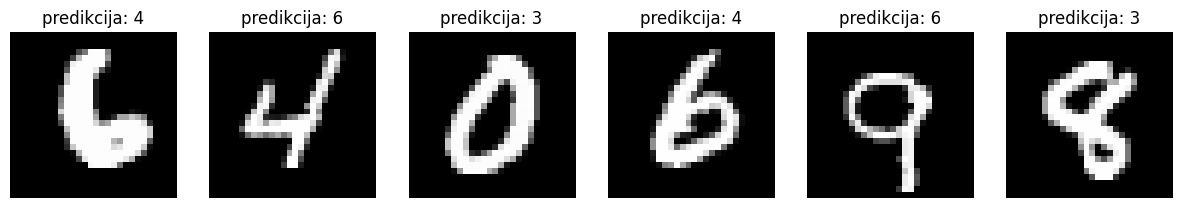

In [50]:
plot_predictions(x_test, predictions, 6)

In [51]:
# malo kompleksnija mreza
net = Network()

net.add(FCLayer(28*28, 256, sigmoid, sigmoid_prime))

net.add(FCLayer(256, 64, sigmoid, sigmoid_prime))

net.add(FCLayer(64, 32, sigmoid, sigmoid_prime))

net.add(FCLayer(32, 10, sigmoid, sigmoid_prime))

In [56]:
net.use(mse, mse_prime)
net.fit_stochastic_gradient_descent(x_train, y_train, epochs=10000, learning_rate=0.01, print_interval=1000)

In [ ]:
predictions = net.predict(x_test)

In [ ]:
print(classification_report(y_test, to_categorical(np.argmax(np.reshape(np.array(predictions), (-1,10)), axis=1), num_classes=10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.23      1.00      0.37      1135
           2       0.27      0.45      0.33      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.34      0.05      0.09       892
           6       0.00      0.00      0.00       958
           7       0.59      0.15      0.24      1028
           8       0.00      0.00      0.00       974
           9       0.31      0.89      0.46      1009

   micro avg       0.27      0.27      0.27     10000
   macro avg       0.17      0.25      0.15     10000
weighted avg       0.18      0.27      0.15     10000
 samples avg       0.27      0.27      0.27     10000



/home/vladimir/GoogleDrive/lanaco/lanaco_praksa/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


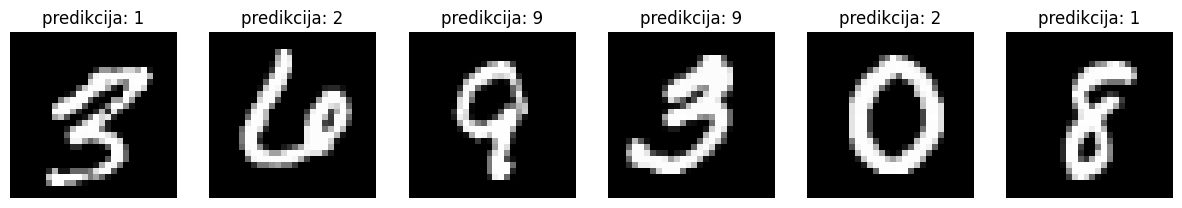

In [ ]:
plot_predictions(x_test, predictions, 6)